# Phase 3: Network stuff

Try to see if coins are more connected in fear vs greed

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

print("loaded")

loaded


## Load data

In [34]:
df = pd.read_csv('../data/processed/full_market_matrix.csv')
df['date'] = pd.to_datetime(df['Date'])

print("Shape:", df.shape)
print("Dates:", df['Date'].min(), "to", df['Date'].max())

Shape: (2926, 23)
Dates: 2018-01-01 to 2026-01-04


## Get clusters from Phase 2

In [35]:
# get coin columns
coin_cols = [col for col in df.columns if col not in ['Date', 'date', 'fg_raw']]
print(f"Coins: {len(coin_cols)}")

# calc returns
for coin in coin_cols:
    df[f'ret_{coin}'] = np.log(df[coin] / df[coin].shift(1))

# same features from Phase 2 (after feature selection)
# TODO: update this based on what features were selected in Phase 2
# so it is 'ret_btc', 'vol_btc_7', 'fg_norm', 'pct_above_ma50'
df['ret_btc'] = df['ret_BTC']
df['vol_btc_7'] = df['ret_BTC'].rolling(7).std() * np.sqrt(365)
df['fg_norm'] = df['fg_raw'] / 100

# ret_cols = [f'ret_{coin}' for coin in coin_cols]
# df['pct_positive'] = (df[ret_cols] > 0).sum(axis=1) / len(coin_cols)


# try MA50 thing
for coin in coin_cols:
    df[f'ma50_{coin}'] = df[coin].rolling(50).mean()

ma_cols = [f'ma50_{coin}' for coin in coin_cols]

# how many coins are above their MA50 each day
df['pct_above_ma50'] = sum(df[coin] > df[f'ma50_{coin}'] for coin in coin_cols) / len(coin_cols)

print("features ready")

Coins: 20
features ready


In [36]:
# cluster (use same features as selected in Phase 2)
# TODO: update this list based on Phase 2 feature selection results
feature_cols = ['ret_btc', 'vol_btc_7', 'fg_norm', 'pct_above_ma50']
df_feat = df[['date'] + feature_cols].dropna()

scaler = StandardScaler()
X = scaler.fit_transform(df_feat[feature_cols])

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_feat['cluster'] = kmeans.fit_predict(X)

df = df.merge(df_feat[['date', 'cluster']], on='date', how='left')

print("Clusters:")
print(f"Cluster 0: {(df_feat['cluster']==0).sum()} days")
print(f"Cluster 1: {(df_feat['cluster']==1).sum()} days")

Clusters:
Cluster 0: 1571 days
Cluster 1: 1324 days


## Build correlation matrices

to compare correlations in fear vs greed periods, across entire period

if fear >  base, pannic drives herd behavior

if greed < base rational individual choices, dependently

In [ ]:
# get clean return data
df_returns = df[['date', 'cluster'] + ret_cols].dropna()

print(f"Data: {df_returns.shape[0]} days")

# calculate baseline: overall correlation across entire period
corr_full = df_returns[ret_cols].corr()
corr_full.columns = coin_cols
corr_full.index = coin_cols

mean_corr_full = corr_full.values[np.triu_indices_from(corr_full.values, k=1)].mean()
print(f"\nFull period mean corr: {mean_corr_full:.3f}")

Data: 1920 days

Full period mean corr: 0.516


Fear: 919 days
Greed: 1001 days

Fear mean corr:  0.647
Greed mean corr: 0.426
Difference: 0.221


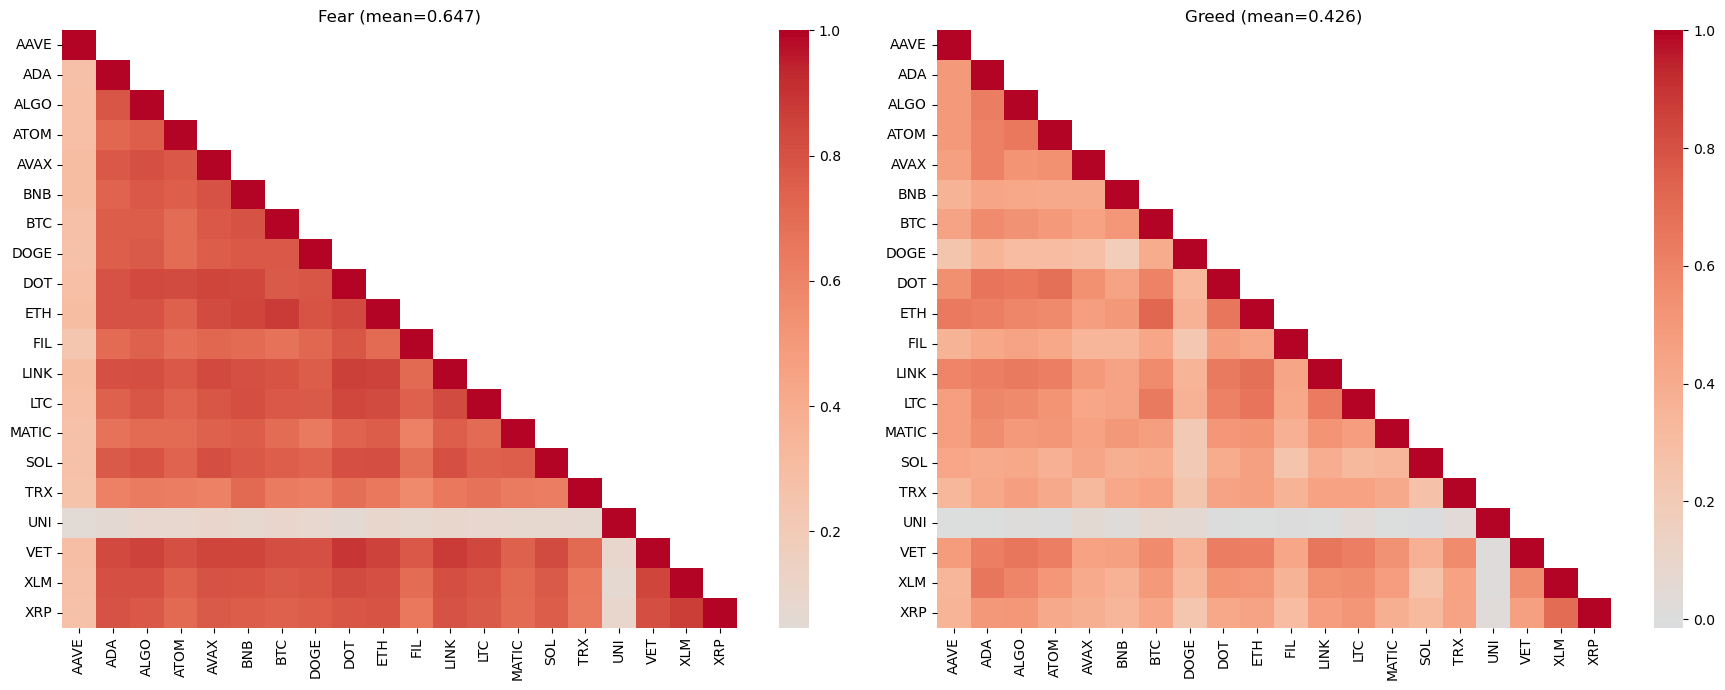


Fear shows higher correlations


In [ ]:
# split by regime
df_fear = df_returns[df_returns['cluster'] == 0]
df_greed = df_returns[df_returns['cluster'] == 1]

print(f"Fear: {len(df_fear)} days")
print(f"Greed: {len(df_greed)} days")

# calc correlations for each regime
corr_fear = df_fear[ret_cols].corr()
corr_greed = df_greed[ret_cols].corr()

corr_fear.columns = coin_cols
corr_fear.index = coin_cols
corr_greed.columns = coin_cols
corr_greed.index = coin_cols

# just show upper
mean_corr_fear = corr_fear.values[np.triu_indices_from(corr_fear.values, k=1)].mean()
mean_corr_greed = corr_greed.values[np.triu_indices_from(corr_greed.values, k=1)].mean()

print(f"\nFear mean corr:  {mean_corr_fear:.3f}")
print(f"Greed mean corr: {mean_corr_greed:.3f}")
print(f"Difference: {mean_corr_fear - mean_corr_greed:.3f}")

# plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

mask = np.triu(np.ones_like(corr_fear, dtype=bool), k=1)
sns.heatmap(corr_fear, mask=mask, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title(f'Fear (mean={mean_corr_fear:.3f})')

sns.heatmap(corr_greed, mask=mask, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title(f'Greed (mean={mean_corr_greed:.3f})')

plt.tight_layout()
plt.show()

if mean_corr_fear > mean_corr_greed:
    print("\nFear shows higher correlations")
else:
    print("\nHmm, unexpected...")

## Build network graphs

Use correlations >0.5 to make edges

In [39]:
# simple function to build network
def make_network(corr_matrix, threshold=0.5):
    G = nx.Graph()
    nodes = corr_matrix.columns.tolist()
    G.add_nodes_from(nodes)
    
    for i, coin1 in enumerate(nodes):
        for j, coin2 in enumerate(nodes):
            if i < j:
                corr = corr_matrix.loc[coin1, coin2]
                if abs(corr) >= threshold:
                    G.add_edge(coin1, coin2, weight=abs(corr))
    
    return G

In [ ]:
# build networks
# here only connect the col > 0.5
G_fear = make_network(corr_fear, threshold=0.5)
G_greed = make_network(corr_greed, threshold=0.5)

print(f"\nFear network:")
print(f"  Nodes: {G_fear.number_of_nodes()}")
print(f"  Edges: {G_fear.number_of_edges()}")
print(f"  Density: {nx.density(G_fear):.3f}")

print(f"\nGreed network:")
print(f"  Nodes: {G_greed.number_of_nodes()}")
print(f"  Edges: {G_greed.number_of_edges()}")
print(f"  Density: {nx.density(G_greed):.3f}")

density_diff = nx.density(G_fear) - nx.density(G_greed)
print(f"\nDensity difference: {density_diff:.3f}")


Fear network:
  Nodes: 20
  Edges: 153
  Density: 0.805

Greed network:
  Nodes: 20
  Edges: 65
  Density: 0.342

Density difference: 0.463


## Visualize networks

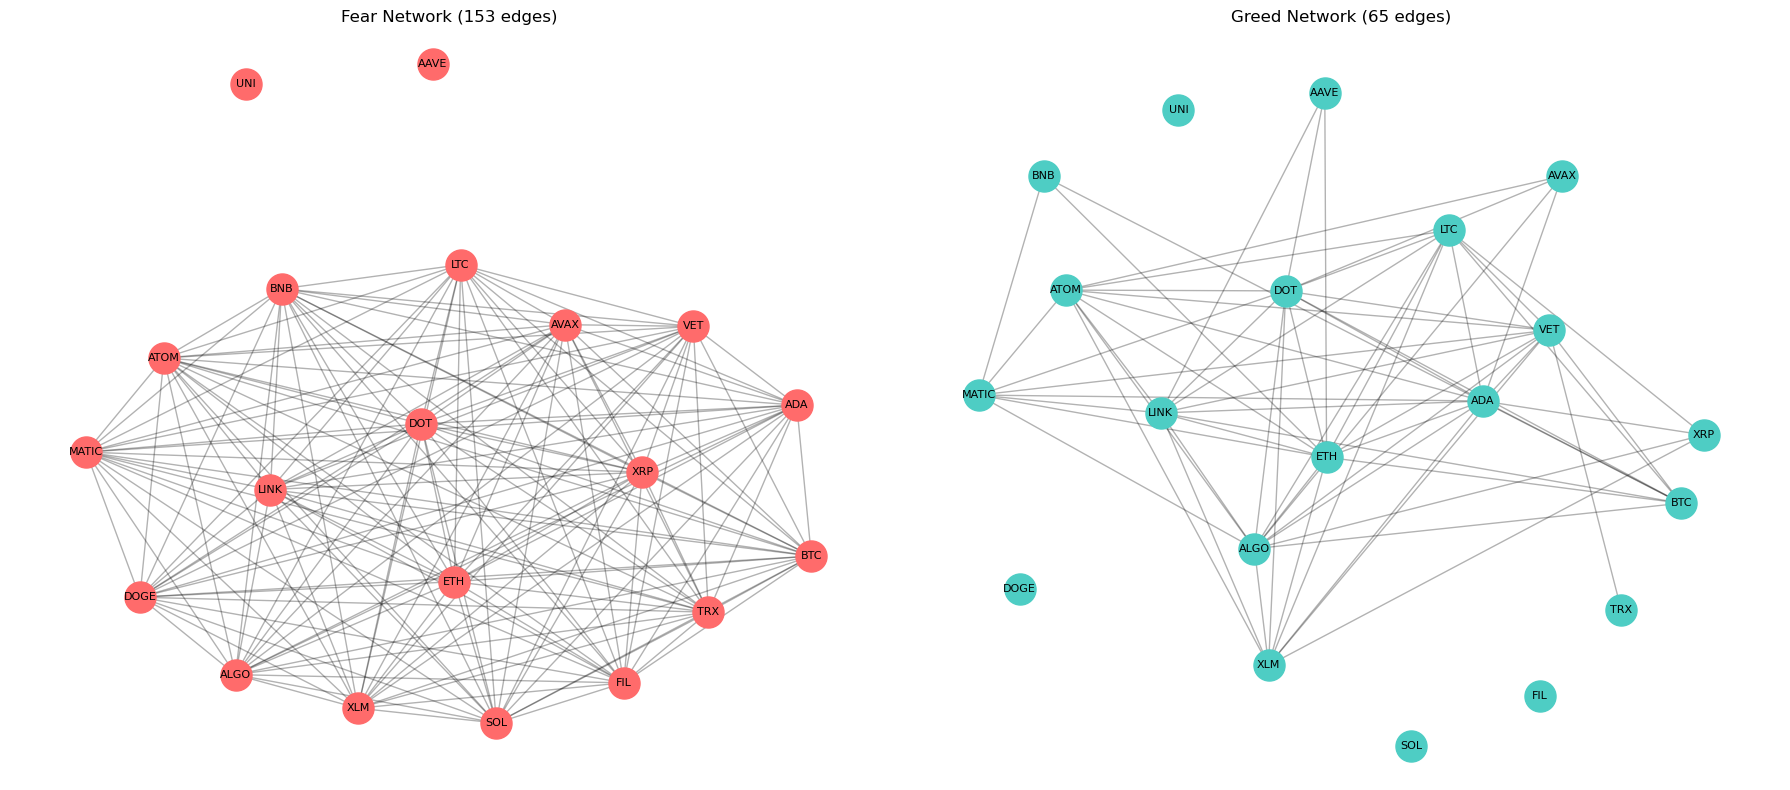

Fear network is much more connected


In [ ]:
# plot fear and greed networks
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# fear - use tighter layout by reducing k and increasing iterations
ax = axes[0]
pos = nx.spring_layout(G_fear, k=2.75, iterations=50, seed=42) 
nx.draw_networkx_nodes(G_fear, pos, node_color='#FF6B6B', node_size=500, ax=ax)
nx.draw_networkx_edges(G_fear, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G_fear, pos, font_size=8, ax=ax)
ax.set_title(f'Fear Network ({G_fear.number_of_edges()} edges)')
ax.axis('off')

# greed - same tight layout
ax = axes[1]
pos = nx.spring_layout(G_greed, k=2.15, iterations=50, seed=42)  
nx.draw_networkx_nodes(G_greed, pos, node_color='#4ECDC4', node_size=500, ax=ax)
nx.draw_networkx_edges(G_greed, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G_greed, pos, font_size=8, ax=ax)
ax.set_title(f'Greed Network ({G_greed.number_of_edges()} edges)')
ax.axis('off')

plt.tight_layout()
plt.show()

print("Fear network is much more connected")

## Calculate network metrics

In [42]:
# some basic metrics
print("Fear network metrics:")
print(f"  Avg degree: {np.mean([d for n, d in G_fear.degree()]):.2f}")
print(f"  Avg clustering: {nx.average_clustering(G_fear):.3f}")

print("\nGreed network metrics:")
print(f"  Avg degree: {np.mean([d for n, d in G_greed.degree()]):.2f}")
print(f"  Avg clustering: {nx.average_clustering(G_greed):.3f}")

Fear network metrics:
  Avg degree: 15.30
  Avg clustering: 0.900

Greed network metrics:
  Avg degree: 6.50
  Avg clustering: 0.599


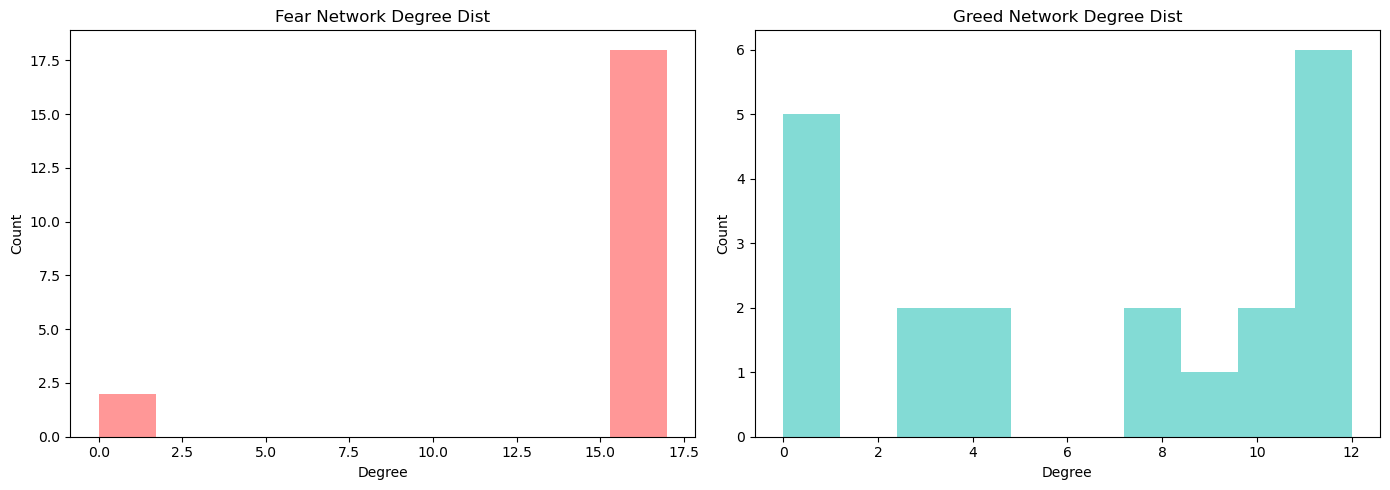

Fear network nodes have higher degrees on average


In [43]:
# plot degree distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# fear
degrees_fear = [d for n, d in G_fear.degree()]
axes[0].hist(degrees_fear, bins=10, color='#FF6B6B', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')
axes[0].set_title('Fear Network Degree Dist')

# greed
degrees_greed = [d for n, d in G_greed.degree()]
axes[1].hist(degrees_greed, bins=10, color='#4ECDC4', alpha=0.7)
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Count')
axes[1].set_title('Greed Network Degree Dist')

plt.tight_layout()
plt.show()

print("Fear network nodes have higher degrees on average")

## Find most important coins

In [44]:
# degree centrality (how connected each coin is)
deg_cent_fear = nx.degree_centrality(G_fear)
deg_cent_greed = nx.degree_centrality(G_greed)

print("Top 5 in Fear:")
for coin, cent in sorted(deg_cent_fear.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {coin}: {cent:.3f}")

print("\nTop 5 in Greed:")
for coin, cent in sorted(deg_cent_greed.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {coin}: {cent:.3f}")

Top 5 in Fear:
  ADA: 0.895
  ALGO: 0.895
  ATOM: 0.895
  AVAX: 0.895
  BNB: 0.895

Top 5 in Greed:
  ADA: 0.632
  ALGO: 0.632
  DOT: 0.632
  ETH: 0.632
  LINK: 0.579


## Save results

In [45]:
# save cluster labels for next phase
df_feat[['date', 'cluster']].to_csv('../data/processed/regime_labels.csv', index=False)

print("Saved regime labels to regime_labels.csv")
print(f"Total: {len(df_feat)} days")

Saved regime labels to regime_labels.csv
Total: 2895 days


In [ ]:
# COMPLETE NETWORK STATISTICS FOR REPORT - ALL TABLES
print("TABLE 6: NETWORK DENSITY COMPARISON (Section 5.4.1)")

print(f"\nFear Regime Network:")
print(f"  Edges: {G_fear.number_of_edges()}")
print(f"  Density: {nx.density(G_fear):.3f}")
print(f"  Mean Correlation: {mean_corr_fear:.3f}")

print(f"\nGreed Regime Network:")
print(f"  Edges: {G_greed.number_of_edges()}")
print(f"  Density: {nx.density(G_greed):.3f}")
print(f"  Mean Correlation: {mean_corr_greed:.3f}")

print(f"\nRatios:")
print(f"  Edges Ratio: {G_fear.number_of_edges() / G_greed.number_of_edges():.2f}x")
print(f"  Density Ratio: {nx.density(G_fear) / nx.density(G_greed):.2f}x")
print(f"  Correlation Ratio: {mean_corr_fear / mean_corr_greed:.2f}x")

print("TABLE 7: CLUSTERING COEFFICIENT (Section 5.4.3)")

clust_fear = nx.average_clustering(G_fear)
clust_greed = nx.average_clustering(G_greed)
print(f"\nFear Regime Clustering Coefficient: {clust_fear:.3f}")
print(f"Greed Regime Clustering Coefficient: {clust_greed:.3f}")

print("TABLE 8: DEGREE CENTRALITY TOP 5 (Section 5.4.4)")

# Sort by centrality
deg_cent_fear_sorted = sorted(deg_cent_fear.items(), key=lambda x: x[1], reverse=True)[:5]
deg_cent_greed_sorted = sorted(deg_cent_greed.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nFear Regime Top 5:")
for asset, cent in deg_cent_fear_sorted:
    print(f"  {asset}: {cent:.3f}")

print("\nGreed Regime Top 5:")
for asset, cent in deg_cent_greed_sorted:
    print(f"  {asset}: {cent:.3f}")

print("\n" + "="*75)


TABLE 6: NETWORK DENSITY COMPARISON (Section 5.4.1)

Fear Regime Network:
  Edges: 153
  Density: 0.805
  Mean Correlation: 0.647

Greed Regime Network:
  Edges: 65
  Density: 0.342
  Mean Correlation: 0.426

Ratios:
  Edges Ratio: 2.35x
  Density Ratio: 2.35x
  Correlation Ratio: 1.52x

TABLE 7: CLUSTERING COEFFICIENT (Section 5.4.3)

Fear Regime Clustering Coefficient: 0.900
Greed Regime Clustering Coefficient: 0.599

TABLE 8: DEGREE CENTRALITY TOP 5 (Section 5.4.4)

Fear Regime Top 5:
  ADA: 0.895
  ALGO: 0.895
  ATOM: 0.895
  AVAX: 0.895
  BNB: 0.895

Greed Regime Top 5:
  ADA: 0.632
  ALGO: 0.632
  DOT: 0.632
  ETH: 0.632
  LINK: 0.579

